In [7]:
import os
import numpy as np
import tensorflow as tf
import random

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load training data
# Fix: use regex separator to handle extra whitespace
train = pd.read_csv("train.csv", sep=r"\s+", engine='python', header=None)

# Now verify how many columns the file really has
print(f"Number of columns: {train.shape[1]}")
train.columns = ['unit', 'time'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]

# Generate RUL labels
rul_df = train.groupby('unit')['time'].max().reset_index()
rul_df.columns = ['unit', 'max_time']
train = train.merge(rul_df, on='unit', how='left')
train['RUL'] = train['max_time'] - train['time']
train.drop('max_time', axis=1, inplace=True)
print(rul_df)


Number of columns: 26
     unit  max_time
0       1       223
1       2       164
2       3       150
3       4       159
4       5       357
..    ...       ...
213   214       150
214   215       156
215   216       190
216   217       287
217   218       133

[218 rows x 2 columns]


Selected 7 features after filtering.
PCA reduced features to 2 components.
Epoch 1/50
493/493 [==============================] - 10s 19ms/step - loss: 5304.1172 - mae: 61.8194 - val_loss: 3771.4937 - val_mae: 52.4041
Epoch 2/50
493/493 [==============================] - 9s 19ms/step - loss: 2962.0383 - mae: 46.9001 - val_loss: 2382.1160 - val_mae: 42.9884
Epoch 3/50
493/493 [==============================] - 9s 19ms/step - loss: 2150.1577 - mae: 41.1750 - val_loss: 1966.2350 - val_mae: 39.6529
Epoch 4/50
493/493 [==============================] - 9s 19ms/step - loss: 1946.8740 - mae: 39.3702 - val_loss: 1884.6062 - val_mae: 38.6916
Epoch 5/50
493/493 [==============================] - 9s 19ms/step - loss: 1920.1644 - mae: 38.9175 - val_loss: 1874.0199 - val_mae: 38.4552
Epoch 6/50
493/493 [==============================] - 9s 19ms/step - loss: 1917.4901 - mae: 38.7982 - val_loss: 1872.8136 - val_mae: 38.4013
Epoch 7/50
493/493 [==============================] - 9s 19ms/step - loss: 191

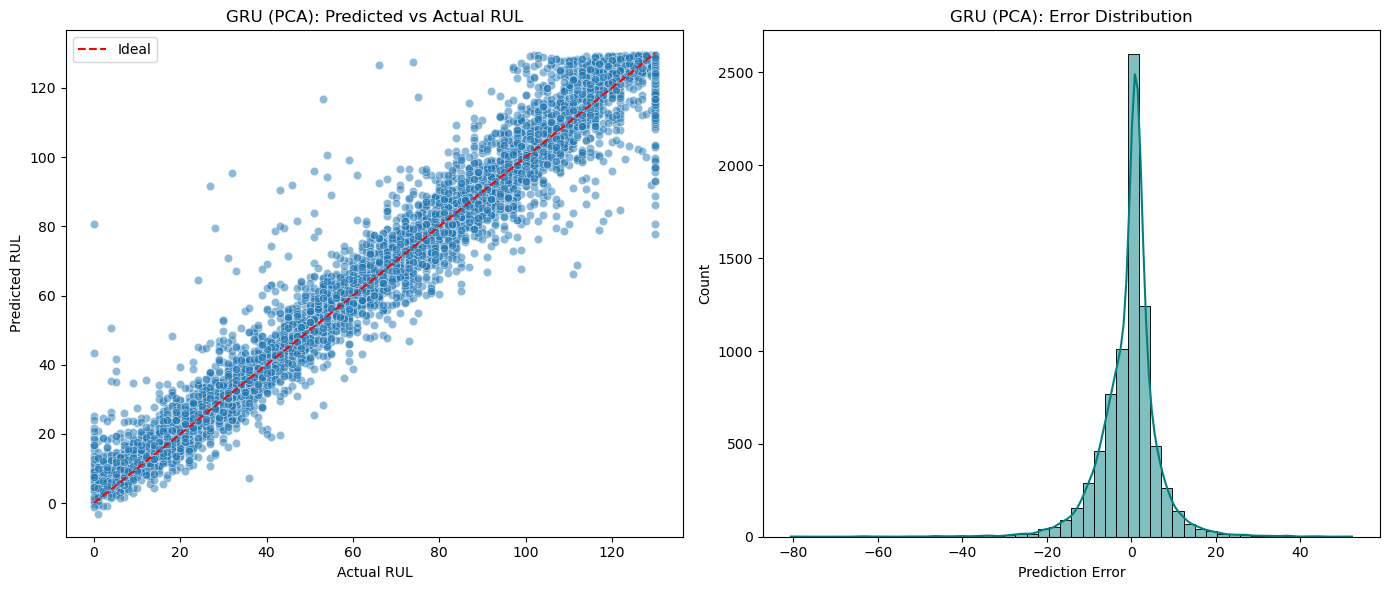

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# STEP 1: Preprocessing
# ---------------------------
MAX_RUL = 130
SEQUENCE_LENGTH = 30
train['RUL'] = train['RUL'].clip(upper=MAX_RUL)

# Initial feature set
raw_features = train.columns.difference(['unit', 'time', 'RUL'])
X_raw = train[raw_features]

# ---------------------------
# STEP 2: Feature Selection
# ---------------------------

# 1. Remove near-zero variance columns
variances = X_raw.var()
selected_features = variances[variances > 1e-5].index.tolist()

# 2. Correlation with RUL (optional — only keep features with abs(corr) > 0.1)
corr_matrix = train[selected_features + ['RUL']].corr()
rul_corr = corr_matrix['RUL'].drop('RUL')
selected_features = rul_corr[abs(rul_corr) > 0.02].index.tolist()
if len(selected_features) == 0:
    selected_features = rul_corr.index.tolist()
    print("No strong correlations found. Using all non-flat features.")

# selected_features = rul_corr[abs(rul_corr) > 0.1].index.tolist()

print(f"Selected {len(selected_features)} features after filtering.")

# Normalize selected features
scaler = MinMaxScaler()
train[selected_features] = scaler.fit_transform(train[selected_features])

# ---------------------------
# STEP 3: PCA for Dimensionality Reduction
# ---------------------------
# Reduce to top N components (retain 95% variance)
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train[selected_features])

print(f"PCA reduced features to {train_pca.shape[1]} components.")

# Replace the training data with PCA-transformed features
train_pca_df = pd.DataFrame(train_pca)
train_pca_df['unit'] = train['unit'].values
train_pca_df['time'] = train['time'].values
train_pca_df['RUL'] = train['RUL'].values

# ---------------------------
# STEP 4: Sequence Generation from PCA Data
# ---------------------------
feature_cols_pca = train_pca_df.columns.difference(['unit', 'time', 'RUL'])

def generate_sequences(df, seq_len):
    sequences, targets = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].sort_values('time')
        for i in range(len(unit_df) - seq_len):
            seq = unit_df.iloc[i:i+seq_len][feature_cols_pca].values
            label = unit_df.iloc[i+seq_len]['RUL']
            sequences.append(seq)
            targets.append(label)
    return np.array(sequences), np.array(targets)

X, y = generate_sequences(train_pca_df, SEQUENCE_LENGTH)

# ---------------------------
# STEP 5: Train/Validation Split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# STEP 6: GRU Model
# ---------------------------
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ---------------------------
# STEP 7: Train
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# STEP 8: Evaluate & Plot
# ---------------------------
y_pred = model.predict(X_val).flatten()
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print(f"\n📉 GRU with Feature Selection + PCA:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")

# ---------------------------
# STEP 9: Visualization
# ---------------------------
errors = y_val - y_pred

plt.figure(figsize=(14, 6))

# 1. Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Ideal')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("GRU (PCA): Predicted vs Actual RUL")
plt.legend()

# 2. Error distribution
plt.subplot(1, 2, 2)
sns.histplot(errors, bins=50, kde=True, color='teal')
plt.xlabel("Prediction Error")
plt.title("GRU (PCA): Error Distribution")

plt.tight_layout()
plt.savefig("gru_pca_rul_prediction.png", dpi=300)
plt.show()


In [9]:
# Filter out samples with very small true RULs
mask = y_val > 10
filtered_y_val = y_val[mask]
filtered_y_pred = y_pred[mask]

errors = filtered_y_val - filtered_y_pred
squared_errors = errors ** 2
mse = np.mean(squared_errors)
mse_min = np.min(squared_errors)
mse_max = np.max(squared_errors)

percentage_errors = (errors / filtered_y_val) * 100
mpe = np.mean(percentage_errors)
mpe_min = np.min(percentage_errors)
mpe_max = np.max(percentage_errors)

print("📊 Filtered Model Performance Summary (RUL > 10 only):")
print(f"MSE: {mse:.2f} ({mse_min:.2f} - {mse_max:.2f})")
print(f"MPE: {mpe:.2f}% ({mpe_min:.2f}% - {mpe_max:.2f}%)")


📊 Filtered Model Performance Summary (RUL > 10 only):
MSE: 49.35 (0.00 - 4198.21)
MPE: -1.61% (-239.98% - 79.47%)


In [10]:
model.save("gru_rul_model.h5")

In [11]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

In [12]:
import joblib
joblib.dump(selected_features, "selected_features.pkl")

['selected_features.pkl']